# **TP3:  Generative Adversarial Networks**
- **Nom: Massyl Yanis HAMDI**
- **Num: 21118208**

## **Objectif de ce TP**

L’objectif de ce TP est d’implémenter une architecture neuronale complexe, comme les réseaux génératifs antagonistes, pour apprendre à générer des images. Le TP est aussi l’occasion
d’appréhender en TF l’apprentissage de réseaux complexes avec des fonctions de pertes qui n’affectent qu’une partie des poids du réseau seulement. Nous utiliserons la base de chiffres MNIST
accessibles depuis le module dataset de Keras.

## **Architecture d'un GAN**

![Image Description](https://miro.medium.com/v2/resize:fit:1400/1*uTFUp2PzqfVu0WMOE-hilA.png)


image source : https://towardsdatascience.com/drawing-architecure-building-deep-convolutional-gans-in-pytorch-5ed60348d43c

## **Importation des données**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

In [ ]:
# Chargement des données MNIST depuis tf.keras.datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Shape de nos données
print('X_train shape: ',x_train.shape)

X_train shape:  (60000, 28, 28)


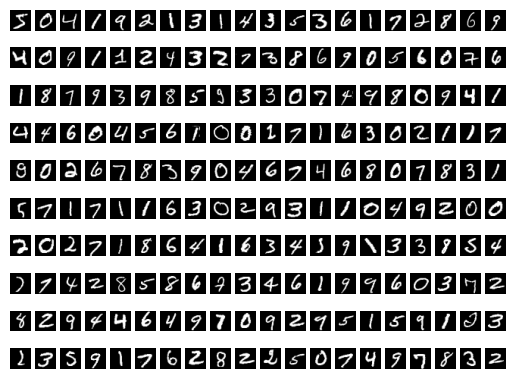

In [ ]:
# Affichage de quelque images de la dataset
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_train[i,:], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# Process image
def preprocess_images(images):
    # Reshape des images pour avoir la data avec le shape (28,28,1)
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
    # Convertit le type de données en float32
    images = images.astype('float32')
    # Normalise les images
    images =  (images - 127.5) / 127.5
    return images

X_train = preprocess_images(x_train)

In [ ]:
# Le nouveau shape
print('X_train shape: ',X_train.shape)

X_train shape:  (60000, 28, 28, 1)


## **Instanciation de G et D**

1. Créer un générateur G avec une architecture CNN. On rappelle que la dimension de l’entrée de G est un code latent aléatoire dont on fixera la dimension à 32, et la dimensionde la sortie correspond à la tailles des images (pour MNIST, 28x28). On prendra plusieurs couches CNN avec les spécifications suivantes :  
— Une première couche Dense qui transforme l’entrée du générateur dans une carte
d’activation de dimension (14x14x128)  
— Des couches Conv2DTranspose avec 128 ou 256 filtres de taille (4x4) ou (5x5).
On remarquera que la couche Conv2DTranspose permet de gérer directement le
UpSampling2D nécessaire pour arriver à une taille d’image désirée, avec le stride
de la convolution transposée.  
— Des fonctions d’activation LeakyReLU  
— Des couches de BatchNormalization  
— On veillera à chaque fois à que les dimensions soient préservées lors des convolutions
successives  

In [ ]:
# Function pour builde le generateur
def build_generator(latent_dim=32):
    model = tf.keras.Sequential()

    # 1er couche Dense
    model.add(tf.keras.layers.Dense(14 * 14 * 128, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((14, 14, 128)))

    # Couches Conv2DTranspose
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    # Couches Conv2DTranspose
    model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    # Couche finale pour avoir {28.28}
    model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='same'))

    return model

In [ ]:
# Builde le generateur
G = build_generator()

# L'architecture
G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             827904    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                         

- Comme on peut voir dans le summary les dimensions sont bien préservées lors des convolutions successives.

1/1 [==============================] - 2s 2s/step


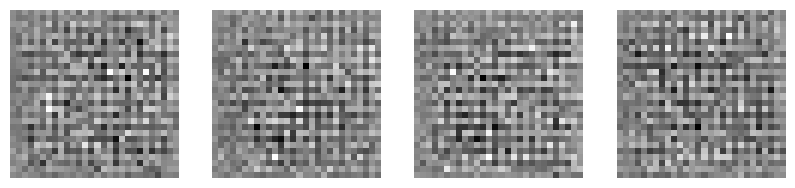

In [ ]:
# Test sur 4 bruits
noise = np.random.normal(0, 1, (4, 32))
generated_images = G.predict(noise)
plt.figure(figsize=(10, 10))
for i in range(len(generated_images)):
    plt.subplot(1, len(generated_images), i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
print(generated_images.shape)

(4, 28, 28, 1)


- Les images sont générées en 28x28, ce qui signifie que les dimensions de l'image sont bien préservées.

2. Créer un discriminateur D avec une architecture CNN. On rappelle que la dimension de l’entrée de D est la tailles des images (réelles ou générées) et que la sortie est un scalaire qui est utilisé pour prendre la décision “réel” ou “faux” On prendra plusieurs couches avec les spécifications suivantes :  
— Une succession de couches Conv2D et de LeakyReLU  
— Une dernière couche dense avec une activation Sigmoid pour faire la prédiction de la décision du discriminateur entre 0 et 1.  

In [ ]:
# fonction pour bulde le discriminator
def build_discriminator():
    model = tf.keras.Sequential()

    # couches Conv2D et LeakyReLU
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape= (28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Aplatir
    model.add(tf.keras.layers.Flatten())

    # Couche dense avec activation Sigmoid
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model



In [ ]:
# Builde le discriminator
D = build_discriminator()

In [ ]:
# L'architecture
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 80769 (315.50 KB)
Trainable params: 8076

In [ ]:
D(generated_images)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.49993932],
       [0.4996687 ],
       [0.5001464 ],
       [0.5000495 ]], dtype=float32)>

## **Création du GAN**

Maintenant que nous avons instancié les deux modules élémentaires G et D, nous allons pouvoir créer le réseau GAN utilisé pour l’apprentissage antagoniste.
3. Pour la partie du discriminateur D, simplement compiler le module D avec la loss binary_crossentropy et l’optimiseur Adam. Utiliser la fonction summary pour visualiser l’architecture de votre réseau D.

In [ ]:
# Fonction loss BCE

D = build_discriminator()
D.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
D.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 80769 (315.50 KB)
Trainable params: 8076

4. Pour la partie du générateur G, l’apprentissage consiste à optimiser les poids du générateur G pour un état donné du discriminateur D.  
— Faire une recopie du discriminateur D pour créer le discriminateur
discriminateur_gan  
— Déclarer les poids de ce discriminateur comme non-entrainables, en fixant la valeur de son attribut trainable à False  
— Instancier le réseau GAN, avec comme entrée la taille du code latent aléatoire et comme sortie la composition de discriminator_gan(generator(gan_input))  
— Définir la loss binary_crossentropy et l’optimiseur Adam

In [ ]:
def build_gan(generator, discriminator):
    # discriminateur
    discriminator_gan = tf.keras.models.Sequential(discriminator.layers)
    discriminator_gan.trainable = False

    # Entrée du GAN
    gan_input = tf.keras.layers.Input(shape=(generator.input_shape[1],))

    # Connecter le générateur et le discriminateur dans le GAN
    gan_output = discriminator_gan(generator(gan_input))

    # Création du modèle GAN
    gan = tf.keras.models.Model(gan_input, gan_output)

    # Compilation du GAN
    gan.compile(loss='binary_crossentropy', optimizer='Adam')

    return gan

# Builde le GAN
gan = build_gan(G, D)

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         992737    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 80769     
                                                                 
Total params: 1073506 (4.10 MB)
Trainable params: 992545 (3.79 MB)
Non-trainable params: 80961 (316.25 KB)
_________________________________________________________________


## **Apprentissage du GAN**

Nous allons maintenant procédé à l’apprentissage alterné des poids du générateur G et du
discriminateur. Pour ce faire, nous allons créer notre propre boucle pour traiter les batches. Nous
reproduirons pour chaque batches les étapes suivantes :


5. Réaliser un tirage aléatoire du code latent, en utilisant un tirage aléatoire dans une distribution normale. Pour ce faire on utilisera la fonction random de numpy.

6. Réaliser la prédiction des images générées à partir de G et du code latent.

7. Construire un mélange d’images réelles tirées aléatoirement et d’images générées avec les
labels correspondant


8. Entrainer le discriminateur D à partir de ce mélange. On utilisera la méthode
train_on_batch

9. Réaliser un nouveau tirage aléatoire du code latent, et créer les labels correspondants à
"réel"


10. Entrainer le réseau antagoniste à partir de ces données. On utilisera la méthode
train_on_batch

In [ ]:
# Fonction pour générées les images
def generate_images(generator, latent_points):
    generated_images = generator.predict(latent_points, verbose=0)
    return generated_images

# Crée une dataset mixte
def create_mixed_dataset(true_data, generated_data, nb_true_data):
    idx = np.random.randint(0, true_data.shape[0], nb_true_data)
    T_samp = true_data[idx]
    # Combiner les images vraies et générées
    mixed_images = np.concatenate([T_samp, generated_data])
    # Créer les étiquettes 1 rt 0
    labels = np.array([1] * nb_true_data + [0] * generated_data.shape[0])

    # Mélanger les images et les étiquettes
    mixed_images, labels = shuffle(mixed_images, labels, random_state=0)

    return mixed_images, labels

Époque 1/200, Avg Loss Dis: 0.18901197103357353, Avg Loss Gan: 1.3911576999989153
Époque 2/200, Avg Loss Dis: 0.1342293866266573, Avg Loss Gan: 0.6235593321216584
Époque 3/200, Avg Loss Dis: 0.2101013049023095, Avg Loss Gan: 1.5135756107974885
Époque 4/200, Avg Loss Dis: 0.28900389064801857, Avg Loss Gan: 2.2081597023643553
Époque 5/200, Avg Loss Dis: 0.18071401919587515, Avg Loss Gan: 2.2652931575430557
Époque 6/200, Avg Loss Dis: 0.15492170678044204, Avg Loss Gan: 2.338000174961053
Époque 7/200, Avg Loss Dis: 0.1603746620749007, Avg Loss Gan: 2.769249792327173
Époque 8/200, Avg Loss Dis: 0.1381950570139452, Avg Loss Gan: 2.534496593521908
Époque 9/200, Avg Loss Dis: 0.1120846692356281, Avg Loss Gan: 2.551175822154619
Époque 10/200, Avg Loss Dis: 0.13723014099377906, Avg Loss Gan: 2.7782579890917987


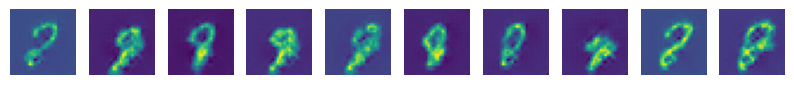

Époque 11/200, Avg Loss Dis: 0.142850441930932, Avg Loss Gan: 2.9844266180880368
Époque 12/200, Avg Loss Dis: 0.08653361655888148, Avg Loss Gan: 3.2721574921160936
Époque 13/200, Avg Loss Dis: 0.10541845444095088, Avg Loss Gan: 3.5125687217805535
Époque 14/200, Avg Loss Dis: 0.10381426384265069, Avg Loss Gan: 3.363553437637165
Époque 15/200, Avg Loss Dis: 0.10510802374483319, Avg Loss Gan: 3.427270812448114
Époque 16/200, Avg Loss Dis: 0.10611276053532492, Avg Loss Gan: 3.0602946679573506
Époque 17/200, Avg Loss Dis: 0.13317638148237165, Avg Loss Gan: 2.72769800608512
Époque 18/200, Avg Loss Dis: 0.11272497242759982, Avg Loss Gan: 2.0384070812033315
Époque 19/200, Avg Loss Dis: 0.1556051480692986, Avg Loss Gan: 2.711545899277553
Époque 20/200, Avg Loss Dis: 0.17701090570517408, Avg Loss Gan: 2.456766689894721


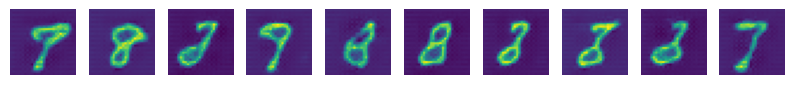

Époque 21/200, Avg Loss Dis: 0.12426703884557355, Avg Loss Gan: 2.1930153493303806
Époque 22/200, Avg Loss Dis: 0.176186061136832, Avg Loss Gan: 2.9287382722832263
Époque 23/200, Avg Loss Dis: 0.17970282203896204, Avg Loss Gan: 2.472474406589754
Époque 24/200, Avg Loss Dis: 0.181555074879725, Avg Loss Gan: 2.6003570470493287
Époque 25/200, Avg Loss Dis: 0.20739623524423223, Avg Loss Gan: 2.7252128256950527
Époque 26/200, Avg Loss Dis: 0.19849695074663032, Avg Loss Gan: 2.426717582391575
Époque 27/200, Avg Loss Dis: 0.21713808078493457, Avg Loss Gan: 2.3193342086160555
Époque 28/200, Avg Loss Dis: 0.1985180326155387, Avg Loss Gan: 2.5045860507525504
Époque 29/200, Avg Loss Dis: 0.2396412890375359, Avg Loss Gan: 2.2281554685905576
Époque 30/200, Avg Loss Dis: 0.2392913667135872, Avg Loss Gan: 2.357932996470481


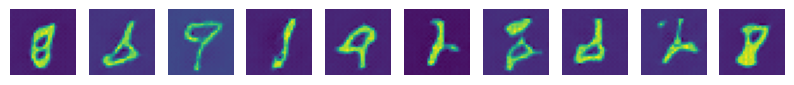

Époque 31/200, Avg Loss Dis: 0.2576903601002414, Avg Loss Gan: 2.3000016398727894
Époque 32/200, Avg Loss Dis: 0.22877090369001962, Avg Loss Gan: 2.2242203175555915
Époque 33/200, Avg Loss Dis: 0.21878602284414228, Avg Loss Gan: 1.9474859572947025
Époque 34/200, Avg Loss Dis: 0.25436437926691724, Avg Loss Gan: 1.575347767531639
Époque 35/200, Avg Loss Dis: 0.27288454421795905, Avg Loss Gan: 1.9288772830041125
Époque 36/200, Avg Loss Dis: 0.29859001422300935, Avg Loss Gan: 1.9924450552789494
Époque 37/200, Avg Loss Dis: 0.3414067240082659, Avg Loss Gan: 1.908499506302178
Époque 38/200, Avg Loss Dis: 0.2946546430757735, Avg Loss Gan: 1.9384908420033753
Époque 39/200, Avg Loss Dis: 0.3016873345186468, Avg Loss Gan: 1.9929713887395337
Époque 40/200, Avg Loss Dis: 0.3053045831620693, Avg Loss Gan: 1.8153784549795091


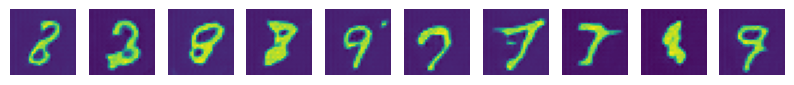

Époque 41/200, Avg Loss Dis: 0.3454007284308318, Avg Loss Gan: 1.5829234226839617
Époque 42/200, Avg Loss Dis: 0.2796047244919464, Avg Loss Gan: 1.2997142928070389
Époque 43/200, Avg Loss Dis: 0.2855009112972766, Avg Loss Gan: 1.4474256939720362
Époque 44/200, Avg Loss Dis: 0.3150834660627879, Avg Loss Gan: 1.2899234895012341
Époque 45/200, Avg Loss Dis: 0.3395561148354318, Avg Loss Gan: 1.4867566401371732
Époque 46/200, Avg Loss Dis: 0.30101199069758877, Avg Loss Gan: 1.4880302004748955
Époque 47/200, Avg Loss Dis: 0.3272822954459116, Avg Loss Gan: 1.4713771789392922
Époque 48/200, Avg Loss Dis: 0.35359092039288953, Avg Loss Gan: 1.5467626731842756
Époque 49/200, Avg Loss Dis: 0.33549570103059523, Avg Loss Gan: 1.422842184721958
Époque 50/200, Avg Loss Dis: 0.35061875375686213, Avg Loss Gan: 1.3815133348107338


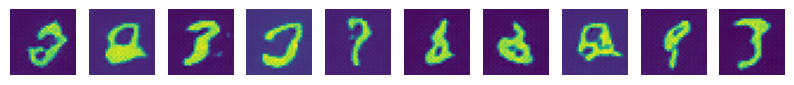

Époque 51/200, Avg Loss Dis: 0.40106792593724094, Avg Loss Gan: 1.5672951829619706
Époque 52/200, Avg Loss Dis: 0.3706393474130891, Avg Loss Gan: 1.4933564433595166
Époque 53/200, Avg Loss Dis: 0.33856220537563786, Avg Loss Gan: 1.6484218502882868
Époque 54/200, Avg Loss Dis: 0.31730363884707913, Avg Loss Gan: 1.4315682947053574
Époque 55/200, Avg Loss Dis: 0.29006219703296665, Avg Loss Gan: 1.2990761132678017
Époque 56/200, Avg Loss Dis: 0.27398275429732166, Avg Loss Gan: 1.2455855443622568
Époque 57/200, Avg Loss Dis: 0.23245070662960643, Avg Loss Gan: 1.072910380702524
Époque 58/200, Avg Loss Dis: 0.2861164191926946, Avg Loss Gan: 1.2536000795080326
Époque 59/200, Avg Loss Dis: 0.296240071678767, Avg Loss Gan: 1.200504900109081
Époque 60/200, Avg Loss Dis: 0.2680913179065101, Avg Loss Gan: 1.1193307588109747


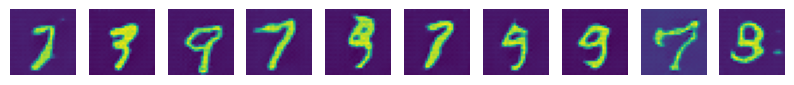

Époque 61/200, Avg Loss Dis: 0.28099385132372845, Avg Loss Gan: 1.2259349170781206
Époque 62/200, Avg Loss Dis: 0.31185832940172986, Avg Loss Gan: 1.248593426134903
Époque 63/200, Avg Loss Dis: 0.2846926372294547, Avg Loss Gan: 0.9027252591040451
Époque 64/200, Avg Loss Dis: 0.2504566948773572, Avg Loss Gan: 1.0456297557684593
Époque 65/200, Avg Loss Dis: 0.3535682217334397, Avg Loss Gan: 1.6005708643933758
Époque 66/200, Avg Loss Dis: 0.28350927894643974, Avg Loss Gan: 1.2801899456535466
Époque 67/200, Avg Loss Dis: 0.24247554939211113, Avg Loss Gan: 1.2311704613966867
Époque 68/200, Avg Loss Dis: 0.2564532483120274, Avg Loss Gan: 1.1927289955492597
Époque 69/200, Avg Loss Dis: 0.2948998708452564, Avg Loss Gan: 1.1180062172934413
Époque 70/200, Avg Loss Dis: 0.2923283448180882, Avg Loss Gan: 1.3807661019382067


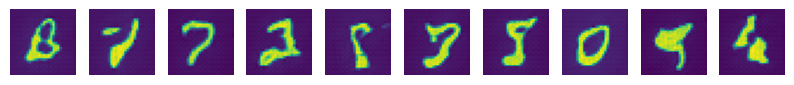

Époque 71/200, Avg Loss Dis: 0.3216707754181698, Avg Loss Gan: 1.3825958428205922
Époque 72/200, Avg Loss Dis: 0.29018382463254966, Avg Loss Gan: 1.295860927857575
Époque 73/200, Avg Loss Dis: 0.2511497514497023, Avg Loss Gan: 1.0555001243774313
Époque 74/200, Avg Loss Dis: 0.2936539443617221, Avg Loss Gan: 1.7200497316662222
Époque 75/200, Avg Loss Dis: 0.2875059120124206, Avg Loss Gan: 1.390560063533485
Époque 76/200, Avg Loss Dis: 0.30980506232299376, Avg Loss Gan: 1.3061181786470115
Époque 77/200, Avg Loss Dis: 0.3045221744978335, Avg Loss Gan: 1.3736331236432306
Époque 78/200, Avg Loss Dis: 0.32456019171513617, Avg Loss Gan: 1.6604638695716858
Époque 79/200, Avg Loss Dis: 0.2829948767757742, Avg Loss Gan: 1.319463049643673
Époque 80/200, Avg Loss Dis: 0.25359730439959094, Avg Loss Gan: 1.3423157762154005


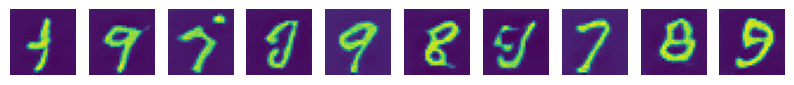

Époque 81/200, Avg Loss Dis: 0.29735573459765874, Avg Loss Gan: 1.3694792526075616
Époque 82/200, Avg Loss Dis: 0.23226542715565301, Avg Loss Gan: 1.3178903301013634
Époque 83/200, Avg Loss Dis: 0.2571908915269887, Avg Loss Gan: 1.0894742396485526
Époque 84/200, Avg Loss Dis: 0.25701775646666647, Avg Loss Gan: 1.2601526570942951
Époque 85/200, Avg Loss Dis: 0.2840500212914776, Avg Loss Gan: 1.4142323239939287
Époque 86/200, Avg Loss Dis: 0.2555020531581249, Avg Loss Gan: 1.5908451522118412
Époque 87/200, Avg Loss Dis: 0.29934715415583923, Avg Loss Gan: 1.4419530367304105
Époque 88/200, Avg Loss Dis: 0.30603114498080686, Avg Loss Gan: 1.7611018381430767
Époque 89/200, Avg Loss Dis: 0.28021223553514574, Avg Loss Gan: 1.5356513590086251
Époque 90/200, Avg Loss Dis: 0.28310142375994474, Avg Loss Gan: 1.7160260883683804


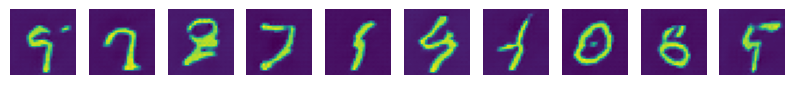

Époque 91/200, Avg Loss Dis: 0.26120937029190827, Avg Loss Gan: 1.3757003532082308
Époque 92/200, Avg Loss Dis: 0.2146990721084876, Avg Loss Gan: 1.246043685474433
Époque 93/200, Avg Loss Dis: 0.26573649857891724, Avg Loss Gan: 1.7284908391302451


In [ ]:
# Paramètres
epochs = 200  # Nombre d'époques
batch_size = 32
latent_dim = 32  # Dimension du code latent

#Train
Avg_Loss_D = []
Avg_Loss_gan = []

for epoch in range(epochs):
    d_loss_cumul = 0
    g_loss_cumul = 0
    for _ in range(256):
        # Tirage
        noise = np.random.normal(0, 1, (32, latent_dim))
        # Img gen
        generated_images = generate_images(G, noise)
        mixed_images, mixed_labels = create_mixed_dataset(X_train, generated_images, 32)
        # Train Dis
        d_loss = D.train_on_batch(mixed_images, mixed_labels)
        # Code Latent
        new_noise = np.random.normal(0, 1, (32, latent_dim))
        # Train du reseau
        misleading_labels = np.ones((32, 1))
        g_loss = gan.train_on_batch(new_noise, misleading_labels)
        d_loss_cumul += d_loss[0]
        g_loss_cumul += g_loss
    d_loss_avg = d_loss_cumul / 256
    g_loss_avg = g_loss_cumul / 256
    print(f"Époque {epoch + 1}/{epochs}, "
          f"Avg Loss Dis: {d_loss_avg}, "
          f"Avg Loss Gan: {g_loss_avg}")
    Avg_Loss_D.append(d_loss_avg)
    Avg_Loss_gan.append(g_loss_avg)
    if (epoch + 1) % 10 == 0:
        # Génération d'img pour le tracé
        noise_for_plot = np.random.normal(0, 1, (10, latent_dim))
        generated_images_for_plot = generate_images(G, noise_for_plot)

        # Tracé des 10 images
        plt.figure(figsize=(10, 10))
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(generated_images_for_plot[i, :, :, :])
            plt.axis('off')
        plt.show()

 - Au fil des epochs, on observe que le modèle apprend progressivement et parvient finalement à générer des images qui ressemblent à la réalité.

## **Test du model**

4/4 [==============================] - 0s 3ms/step


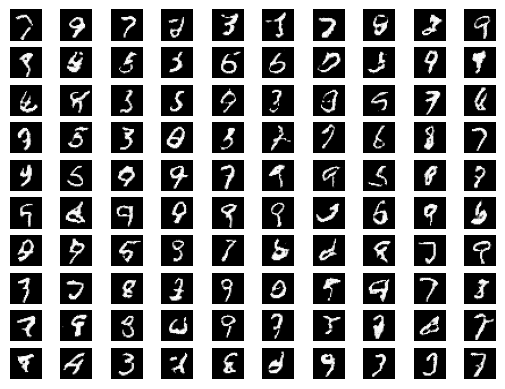

In [ ]:
from tensorflow.keras.preprocessing import image
random_latent_vectors = np.random.normal(size=(100, latent_dim))
generated_images = G.predict(random_latent_vectors)

plt.figure()
for i in range(100):
  img = image.array_to_img(generated_images[i] * 255., scale=False)
  plt.subplot(10,10,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

* On parvient à générer quelques chiffres, mais pas la totalité. La solution est d'augmenter le nombre d'epochs de l'entraînement



Affichage de la courbe des loss

In [ ]:
plt.figure()

plt.plot(Avg_Loss_D, color='skyblue', label='Perte du Discriminateur')
plt.plot(Avg_Loss_gan, color='gold', label='Perte du GAN')
plt.title('Courbes de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()


La courbe ne montre pas de convergence claire vers une valeur de perte basse et stable, ce qui signifie que le générateur n'a pas encore trouvé une stratégie optimale pour tromper le discriminateur.

A note que lorsque l'accuracy du discriminateur atteint une valeur élevée, le générateur a du mal à continuer à apprendre.


#### **Remarque:**
L'entraînement des réseaux antagonistes génératifs (GANs) diffère substantiellement de celui des modèles de réseaux de neurones traditionnels. Au lieu d'utiliser une unique fonction de perte qui guide le modèle vers la convergence, les GANs impliquent une dynamique de compétition entre deux composants : le générateur et le discriminateur, chacun avec sa propre fonction de perte. Cette configuration crée une situation complexe où les deux fonctions de perte ne peuvent être minimisées de manière simultanée, car l'amélioration de l'un peut signifier une détérioration de l'autre.

La convergence vers un équilibre de est l'objectif de cet entraînement, ce qui diffère d'une minimisation de perte simple. C'est pourquoi la perte elle-même ne peut pas être le seul indicateur de progrès ou de la qualité du modèle.